# Monte Carlo Stocking Optimization

In [1]:
import itertools as it

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyomo.environ as pyo

from mciso import model, utils, visualize


plt.style.use("seaborn")
RNG = np.random.default_rng()


In [2]:
sheet_id = "1mPcE2lKxwxgNtohLG5Oj57YzsNV2rL0czuWTUPxHPg8"
sheets = ["Products", "Model_Spec"]
base_url = "https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

prod_spec = pd.read_csv(base_url.format(sheet_id=sheet_id, sheet_name="Products")).set_index(["Product"])
model_spec = pd.read_csv(base_url.format(sheet_id=sheet_id, sheet_name="Model_Spec")).set_index(["parameter"])

prod_df = prod_spec.filter(regex="^(?!cust_)")
cust_df = prod_spec.filter(regex="^cust_").rename(
    columns=lambda x: x.replace("cust_", "")
)

idx_labels = {
    "i": [f"month_{i+1}" for i in range(model_spec.loc["no of months", "value"])],
    "k": prod_df.index.tolist()
}


## Modeling Demand

Monthly demand for each customer is estimated as follows:

In [3]:
cust_df.style.background_gradient(axis=None)

,Hospital A,Hospital B,Hospital C,Hospital D,Hospital E,Clinic 1,Clinic 2,Clinic 3
Product,,,,,,,,
Product 1,10,8,12,15,20,6,4,5
Product 2,8,5,9,14,18,4,2,3
Product 3,2,1,1,5,8,1,1,2
Product 4,2,1,1,4,6,1,1,1
Product 5,2,1,1,5,7,1,1,2


However, in reality, there will be *some* level of uncertainty.  
Hence, demand is modelled as a [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) 

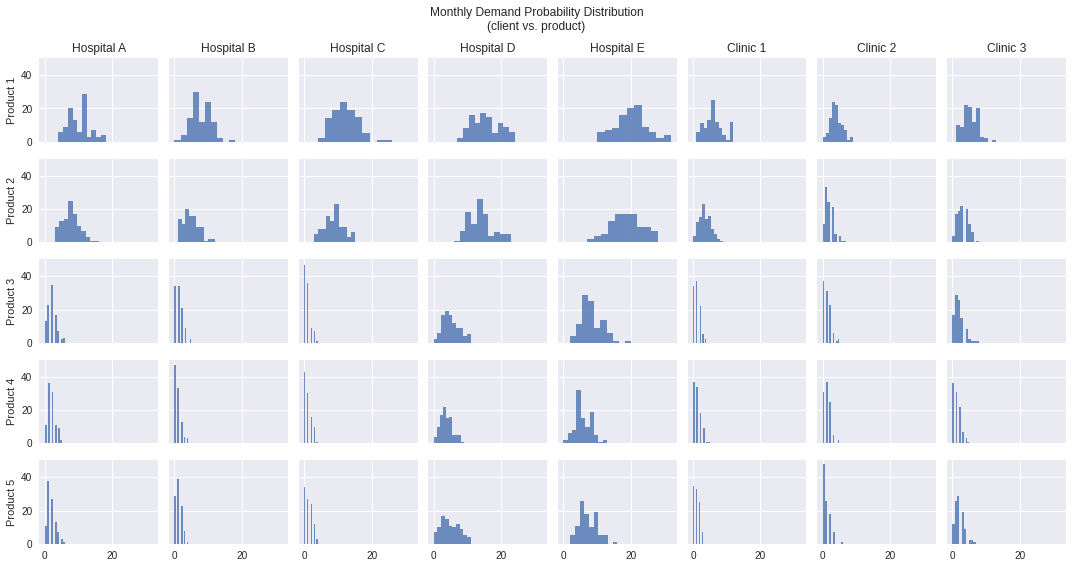

In [4]:
n_samples = 100

fig, ax = plt.subplots(
    *cust_df.shape, figsize=(15, 8), sharex=True, sharey=True
)
fig.suptitle("Monthly Demand Probability Distribution\n(client vs. product)")
for i, row in enumerate(cust_df.index):
    for j, col in enumerate(cust_df.columns):
        ax_i = ax[i, j]
        if i == 0:
            ax_i.set_title(col)
        if j == 0:
            ax_i.set_ylabel(row)

        ax_i.hist(RNG.poisson(lam=cust_df.loc[row, col], size=n_samples), alpha=0.8)

fig.tight_layout()

## Model Parameters

We consider the following parameters:
* working capital: maximum inventory value (i.e. capital tied in inventory)
* no of months
* no of scenarios: # of scenarios we consider to draw from random distribution
  
For each product, the parameters are as follows:
* Unit Price: buy price for each unit of product  
* Sell Price: sell price for each unit of product
* MOQ: minimum order quantity
* Min Stock: minimum stock
* Storage Cost: can be thought of as forgone interest
* Out of Stock Cost: can be thought of as "reputational damage"


In [5]:
display(model_spec.style.format("{:,.0f}"))

display(
    prod_df.drop(columns=["BI", "L"])
    .rename(
        columns={
            "UP": "Unit Price",
            "SP": "Sell Price",
            "LB": "Min Stock",
            "W": "Storage Cost",
            "O": "Out of Stock Cost",
        }
    )
    .style.format("{:,.2f}")
)


,value
parameter,
working capital,"500,000"
no of months,12
no of scenarios,100


,Unit Price,Sell Price,MOQ,Min Stock,Storage Cost,Out of Stock Cost
Product,,,,,,
Product 1,255.15,450.00,300.00,30.00,7.65,389.70
Product 2,546.75,800.00,400.00,20.00,16.40,506.50
Product 3,600.00,800.00,0.00,5.00,18.00,400.00
Product 4,700.00,"1,500.00",0.00,5.00,21.00,"1,600.00"
Product 5,900.00,"1,200.00",0.00,5.00,27.00,600.00


In [6]:
# Generate demand scenarios
# D[n_month, n_scenario, n_sku]
D = RNG.poisson(
    lam=cust_df.values,
    size=[
        model_spec.loc["no of months", "value"],
        model_spec.loc["no of scenarios", "value"],
    ]
    + list(cust_df.shape),
).sum(axis=-1)

Demand scenarios generated are show below:  
* Each gray line represents a scenario
* The blue line represents the "average" of scenarios

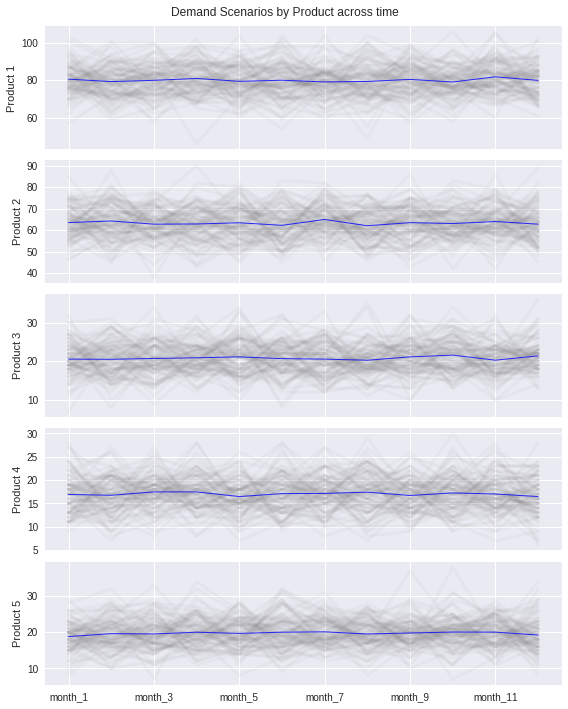

In [7]:
fig, ax = plt.subplots(D.shape[-1], 1, figsize=(8, D.shape[-1] * 2), sharex=True)

visualize.scenarios_by_product(D, idx_labels["i"], prod_df.index, ax=ax)

fig.suptitle("Demand Scenarios by Product across time")
fig.tight_layout()


## Model Optimization

In [8]:
data = {
    None: {
        "n_months": {None: D.shape[0]},
        "n_scenarios": {None: D.shape[1]},
        "n_skus": {None: D.shape[2]},
        "D": utils.array_to_dok(D),
        "BI": utils.array_to_dok(prod_df["BI"].values),
        "UP": utils.array_to_dok(prod_df["UP"].values),
        "SP": utils.array_to_dok(prod_df["SP"].values),
        "MOQ": utils.array_to_dok(prod_df["MOQ"].values),
        "LB": utils.array_to_dok(prod_df["LB"].values),
        "W": utils.array_to_dok(prod_df["W"].values),
        "O": utils.array_to_dok(prod_df["O"].values),
        "L": utils.array_to_dok(prod_df["L"].values),
        "UB": {None: model_spec.loc["working capital", "value"]},
    },
}

abs_model = model.create_model()
model_ins = abs_model.create_instance(data)
opt = pyo.SolverFactory("cbc")

print("Solving model...")
res = opt.solve(model_ins)
print("Done!")

Solving model...
Done!


## Results

In [9]:
X = utils.dok_to_array(model_ins.X.get_values())
V = utils.dok_to_array(model_ins.V.get_values())
S = utils.dok_to_array(model_ins.S.get_values())
s = utils.dok_to_array(model_ins.s.get_values())
d = utils.dok_to_array(model_ins.d.get_values())
z = utils.dok_to_array(model_ins.z.get_values())

X_df = pd.DataFrame(X, index=idx_labels["i"], columns=idx_labels["k"])

V_df = pd.DataFrame(V.mean(axis=1), index=idx_labels["i"], columns=idx_labels["k"])
s_df = pd.DataFrame(s.mean(axis=1), index=idx_labels["i"], columns=idx_labels["k"])
d_df = pd.DataFrame(d.mean(axis=1), index=idx_labels["i"], columns=idx_labels["k"])

The optimal order schedule for each product is shown below:

In [10]:
X_df.style.format("{:.0f}").background_gradient(axis=0)

,Product 1,Product 2,Product 3,Product 4,Product 5
month_1,300,416,33,33,30
month_2,0,0,22,19,21
month_3,0,0,22,17,23
month_4,331,0,27,24,20
month_5,0,0,18,14,22
month_6,0,0,22,19,19
month_7,0,400,21,20,23
month_8,332,0,21,15,18
month_9,0,0,20,18,19
month_10,0,0,22,18,22


### Expected ending inventory

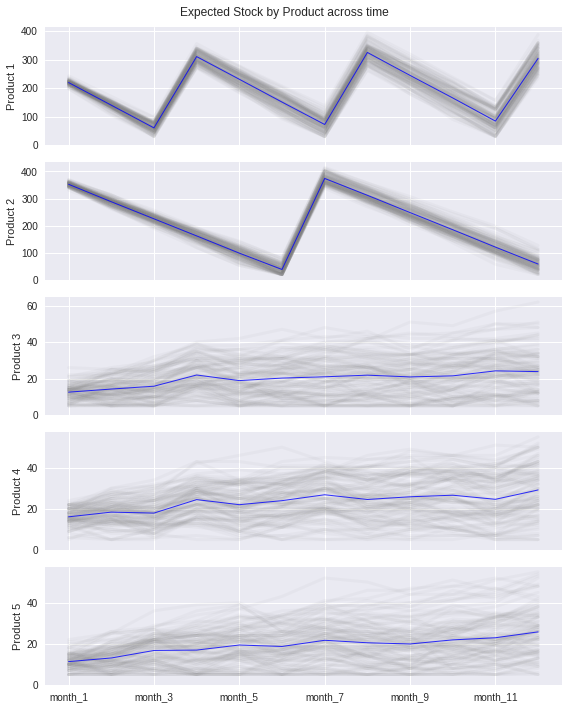

In [11]:
fig, ax = plt.subplots(s.shape[-1], 1, figsize=(8, s.shape[-1] * 2), sharex=True)

visualize.scenarios_by_product(s, idx_labels["i"], prod_df.index, ax=ax)

for ax_i in ax.flatten():
    ax_i.set_ylim(0)

fig.suptitle("Expected Stock by Product across time")
fig.tight_layout()


### Inventory Value

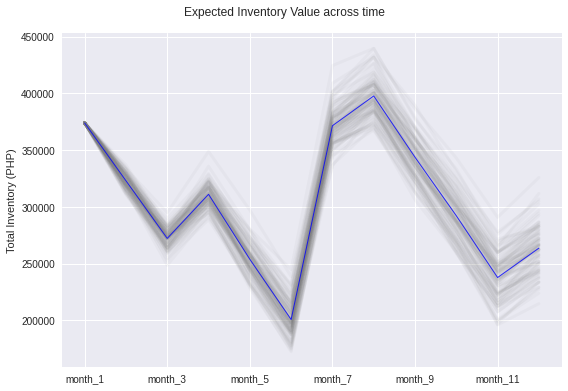

In [12]:
inv_val = (S * prod_df["UP"].values).sum(axis=-1, keepdims=True)

fig, ax = plt.subplots(1,1)
visualize.scenarios_by_product(inv_val, idx_labels["i"], ["Total Inventory (PHP)"], ax=ax)

fig.suptitle("Expected Inventory Value across time")
fig.tight_layout()

### Financial Results

In [13]:
fin_s = pd.Series(dtype="float", name="value")

fin_s["Revenue"] = V_df.mul(prod_df["SP"]).values.sum()
fin_s["COGS"] = - V_df.mul(prod_df["UP"]).values.sum()
fin_s["Contribution Margin"] = fin_s["Revenue"] + fin_s["COGS"]

fin_s["Storage Cost"] = - s_df.mul(prod_df["W"]).values.sum()
fin_s["Out of Stock Cost"] = - d_df.mul(prod_df["O"]).values.sum()

fin_s["Gross Margin"] =  fin_s["Contribution Margin"] + fin_s["Storage Cost"] + fin_s["Out of Stock Cost"] 

fin_s.to_frame().style.format('PHP {:>10,.2f}')

,value
Revenue,"PHP 1,822,653.00"
COGS,"PHP -1,161,076.96"
Contribution Margin,"PHP 661,576.04"
Storage Cost,"PHP -74,392.63"
Out of Stock Cost,"PHP -4,246.89"
Gross Margin,"PHP 582,936.52"
